# Prova Final de Análise Estatística de Dados e Informações

**Aluno:** Adam Victor Nazareht Brandizzi

## Questão 1

Vamos montar um modelo de regressão linear para prever os preços de imóveis da região de King County dos Estados Unidos, usando a base de dados _[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)_. Este exercício têm 5 fases.

### Análise descritiva

Carreguemos o modelo:

In [1]:
from brandedpipes import __
import kagglehub
from glob import glob
from pathlib import Path

datadir = Path(kagglehub.dataset_download("harlfoxem/housesalesprediction"))
print(datadir)
datafiles = __| datadir.glob('*') | list |__
print(datafiles)
datafile = datafiles[0]

/home/adam/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1
[PosixPath('/home/adam/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1/kc_house_data.csv')]


In [2]:
from kagglehub import KaggleDatasetAdapter

# Load the latest version
q1_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "harlfoxem/housesalesprediction",
  datafile.name,
)

q1_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Vejamos que colunas temos:

In [3]:
import pandas as pd

DF = pd.DataFrame

q1_columns_df = DF({
    'type': q1_df.dtypes
})

q1_columns_df

,type
id,int64
date,object
price,float64
bedrooms,int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64


Temos 19 colunas. Queremos um preditor para a coluna `price`:

In [4]:
y = q1_df['price']

Todas as demais colunas são de interesse, exceto por `id`, que é apenas um identificador arbitrário.

A coluna `date` (data da venda) é interessante, porque pode ajudar a modelar informação sobre o estado do mercado em um ponto do tempo. Contudo, vamos ignorá-la porque, numa aplicação do modelo em que a usássemos, teríamos de passar também uma data esperada da venda. Ideia interessante, mas me parece fora do escopo.

In [5]:
X = q1_df.drop(['id', 'price', 'date'], axis=1)

Todas as colunas restantes codificadas como inteiros ou ponto flutuantes. Algumas têm valor categórico evidente, como `waterfront` (que é basicamente um `bool`), `view`, `condition`, `grade` e `zipcode`.

In [6]:
def puv(df, column):
    """
    [P]rint [U]nique [V]alues
    """
    print(f'Valores únicos de {column}:', df[column].unique())
puv(q1_df, 'waterfront')
puv(q1_df, 'view')
puv(q1_df, 'condition')
puv(q1_df, 'grade')
puv(q1_df, 'zipcode')

Valores únicos de waterfront: [0 1]
Valores únicos de view: [0 3 4 2 1]
Valores únicos de condition: [3 5 4 1 2]
Valores únicos de grade: [ 7  6  8 11  9  5 10 12  4  3 13  1]
Valores únicos de zipcode: [98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


Como `waterfront`, representando um valor booleano, já está praticamente na forma _one-hot encoding_, e a maioria das demais possuem uma ordenação intrísceca, não vamos expandi-las. `zipcode`, porém, provavelment precisará ser codificado como _one-hot encoding_.

Note também que não há nenhuma columa com valor em falta. Isso vai nos salvar de casos de borda e é um sinal de qualidade

In [7]:
def gnanc(df):
    """[G]et [NaN] [C]olumns"""
    columns = df.columns
    return DF({
        'column': columns,
        'hasNaN': [df[c].isnull().any() for c in columns]
    })
gnanc(q1_df)

,column,hasNaN
0,id,False
1,date,False
2,price,False
3,bedrooms,False
4,bathrooms,False
5,sqft_living,False
6,sqft_lot,False
7,floors,False
8,waterfront,False
9,view,False


#### Correlação entre variáveis

Antes de mais nada, vamos ver quais entradas têm mais correlação com o preço:

In [8]:
X_y_corr = X.corrwith(y)
DF(X_y_corr).sort_values(by=0)

,0
zipcode,-0.053203
long,0.021626
condition,0.036362
yr_built,0.054012
sqft_lot15,0.082447
sqft_lot,0.089661
yr_renovated,0.126434
floors,0.256794
waterfront,0.266369
lat,0.307003


Com essas informações em mãos, vamos analisar os campos.

##### `zipcode`

A menor correlação é o `zipcode`. Faz sentido: é uma variavel categórica cujo suposto valor numérico nada descreve sobre o imóvel. O fato de ter uma correlação tão baixa é praticamente um bom exemplo de como o valor numérico é aleatório. Ainda assim, ZIP codes registram partes das cidades que diferem drasticametne entre si. De fato, se ordernarmos os ZIP codes por valor médio, obtemos uma relação visualmente muito semelhante a linear em escala logarítmica:

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

zc_means = (
    q1_df.groupby("zipcode")["price"]
      .median()
      .sort_values()
)

zc_df = DF(
    zc_means
)
zc_df['i'] = range(len(zc_means))
zc_df
zc_df[X['zipcode']]

KeyError: "None of [Index([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146, 98038,\n       ...\n       98065, 98144, 98056, 98136, 98116, 98103, 98146, 98144, 98027, 98144],\n      dtype='int64', length=21613)] are in the [columns]"

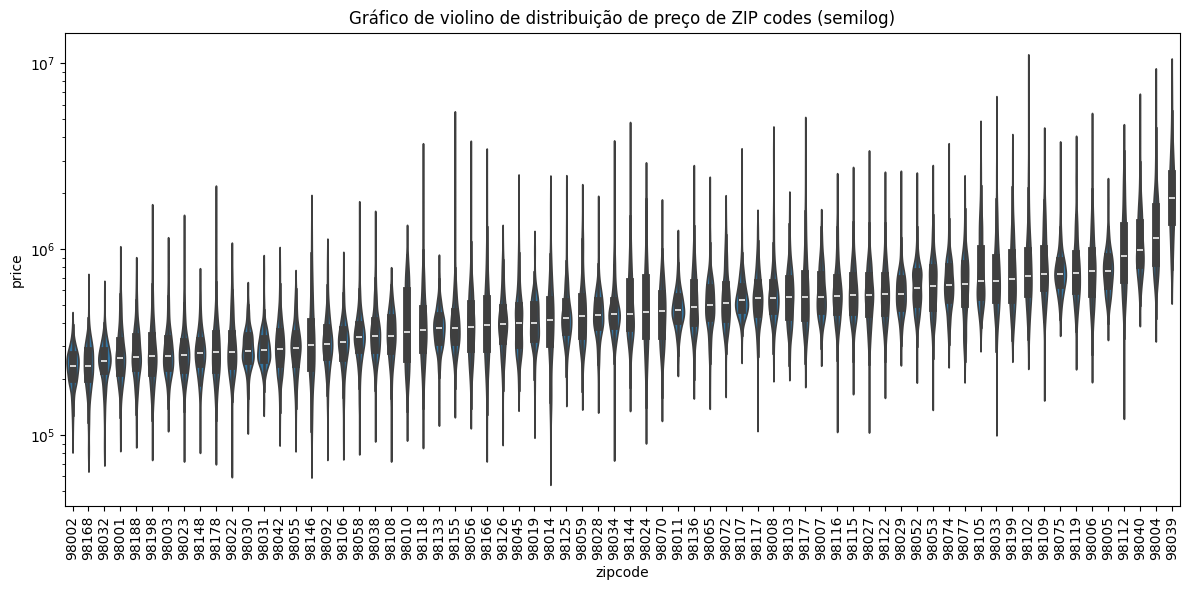

In [46]:
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=q1_df,
    x="zipcode",
    y="price",
    log_scale=True,
    order=zc_means.index,
    inner="box",
)
plt.title('Gráfico de violino de distribuição de preço de ZIP codes (semilog)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Assim, se adicionarmos coluna com o índice do ZIP code ordenado por média, e outra com o logaritmo do preço, temos valores potencialmente correlacioados:

In [ ]:
X['zipcode:i'] = 

##### `lat` e `long`

`long` (longitude) é o seguindo valor menos influente. Isso surpreeende, não só porque não segue a proverbial variação entre leste e oeste [[archplan.buffalo.edu](https://archplan.buffalo.edu/research/research-initiatives/seeitthrough/aschoolanditscity/eastwestdivide.html)] como também porque o condado varia bastante, com muito mais áreas urbanas a oeste:

<div style="max-width:400px">

![Mapa do condado de King](condado-de-king.png)

</div>

Por outro lado, a latitude tem uma correlação até bem alta. Isso é surpreendente já que o condado tem meros 100 km de norte a sul [[your.kingcounty.gov](https://your.kingcounty.gov/dnrp/library/2008/kcr1973/kcr1973.pdf?utm_source=chatgpt.com)], o que por si só não deve causar grande variação em clima, e o mapa mostra certa uniformidade as várias faixas norte-sul. Essa informação deve estar representada (até com mais granuaridade e interpretabilidade) nos ZIP codes, porém. Então vamos descartar a latitude também.

In [ ]:
X = X.drop(['long', 'lat'], axis=1)

#### `sqft_lot` e `sqft_lot15`

Também surpreende a baixa correlação de `sqft_lot` e `sqt_lot15`. Mas aqui há um detalhe: `sqft_lot15`  representa o tamanho médio das propredades à volta. O preço da propriedade provavelmente é mais relacionado ao tamanho da propriedade _em relação aos seus vizinhos_`:

In [12]:
X['sqft_lot:proportion'] = X['sqft_lot']/X['sqft_lot15']
X.corrwith(y)['sqft_lot:proporton']

np.float64(0.04184308159636746)

In [15]:
X['sqft_lot:log'] = np.log1p(X['sqft_lot'])
X.corrwith(y)['sqft_lot:log']

np.float64(0.1613216221849383)

A correlação foi menor ainda! 

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.show()


#### Price

A média  e a mediana (quartil de 50%) do preço (`price`) possuem significatemente differentes, mas relativamente próximos. O menor valor é seis vezes menor que a média, e 100 vezes menor que o máximo. Também notamos um desvio-padrão bem alto, maior que metade da média. O preço claramente varia muito, com poucos valores altos puxando as métricas para cima.

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
q1_df['price'].describe()

Os valores estão distribuídos em uma forma similar a uma distribuição de Poisson, com uma longa cauda de valores bem altos. Isso não afeta a linearidade mas pode exigir balanceamento.

In [ ]:
import plotly.express as px

def h(df, column, bins=10, log=False):
    fig = px.histogram(
        df,
        x=column,
        nbins=bins,
        title=f"Histograma de {column}"
    )
    if log:
        fig.update_yaxes(type="log")
    fig.show()

h(q1_df, 'price', bins=80, log=True)

De fato, notamos que há vários outliers com valores bem altos. Vamos mantê-los pois possuem informação relevante, mas ficaremos de olho para ver se afetam o resultado.



In [ ]:
import math
def boxplot(df, column):
    sns.boxplot(data=df, y=column)
    plt.tight_layout()
    plt.show()
boxplot(q1_df, 'price')

## Balanceamento

In [ ]:
450/75
